In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F 
import numpy as np
import torchvision
import matplotlib.pyplot as plt


In [2]:
train_data=torchvision.datasets.FashionMNIST(root='./FashionMnist_train',train=True,download=True,transform=torchvision.transforms.ToTensor())
test_data=torchvision.datasets.FashionMNIST(root='./FashionMnist_test',train=False,download=True,transform=torchvision.transforms.ToTensor())

In [3]:
BATCH_SIZE=64
train_dataloader=torch.utils.data.DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True)
test_dataloader=torch.utils.data.DataLoader(test_data,batch_size=BATCH_SIZE)

In [6]:
class con_blk(nn.Module):
    def __init__(self,in_ch,out_ch,k_size,str_val=1,p_size=(2,2)):
        super(con_blk,self).__init__()
        self.con=nn.Conv2d(in_ch,out_ch,k_size,str_val)
        self.p_size=p_size
    def forward(self,X):
        C1=F.relu(self.con(X))
        p1=F.max_pool2d(C1,self.p_size[0],self.p_size[1])
        return(p1)


In [7]:
class fashionmnist_convnet(nn.Module):
    def __init__(self):
        super(fashionmnist_convnet,self).__init__()
        self.blk1=con_blk(1,6,3,1)
        self.blk2=con_blk(6,16,3,1)
        self.D1=nn.Linear(16*5*5,128)
        self.D2=nn.Linear(128,64)
        self.D3=nn.Linear(64,10)
    def forward(self,X):
        b1=self.blk1.forward(X)
        b2=self.blk2.forward(b1)
        bf=b2.view(-1,16*5*5)
        D1=F.relu(self.D1(bf))
        D2=F.relu(self.D2(D1))
        D3=self.D3(D2)
        return(D3)



In [8]:
torch.manual_seed(101)
model=fashionmnist_convnet()
model

fashionmnist_convnet(
  (blk1): con_blk(
    (con): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  )
  (blk2): con_blk(
    (con): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  )
  (D1): Linear(in_features=400, out_features=128, bias=True)
  (D2): Linear(in_features=128, out_features=64, bias=True)
  (D3): Linear(in_features=64, out_features=10, bias=True)
)

In [9]:
crit=nn.CrossEntropyLoss()
opt=torch.optim.Adam(model.parameters())

In [10]:
def train_single_epoch(d_loader,mod,opt,crit,disp_int=100):
    running_batch_loss=[]
    for b,ex in enumerate(d_loader):
        opt.zero_grad()
        pred=mod.forward(ex[0])
        loss=crit(pred,ex[1])
        running_batch_loss.append(loss.item())
        loss.backward()
        opt.step()
        if(b%disp_int==0):
            print(f'Batch:{b} Loss:{loss.item():0.4f}')
    return(mod,running_batch_loss)
def train_model(epochs,d_loader,mod,opt,crit,disp_int=100):
    running_epoch_loss=[]
    for i in range(epochs):
        print(f'_____________Epoch:{i}________________')
        mod,running_batch_loss=train_single_epoch(d_loader,mod,opt,crit,disp_int)
        running_epoch_loss.extend(running_batch_loss)
    return(mod,running_epoch_loss)
num_epochs=10
mod,running_epoch_loss=train_model(num_epochs,train_dataloader,model,opt,crit)

_____________Epoch:0________________
Batch:0 Loss:2.3041
Batch:100 Loss:0.9213
Batch:200 Loss:0.8354
Batch:300 Loss:0.6852
Batch:400 Loss:0.9265
Batch:500 Loss:0.7243
Batch:600 Loss:0.5476
Batch:700 Loss:0.6673
Batch:800 Loss:0.5448
Batch:900 Loss:0.5232
_____________Epoch:1________________
Batch:0 Loss:0.4084
Batch:100 Loss:0.5967
Batch:200 Loss:0.4644
Batch:300 Loss:0.5417
Batch:400 Loss:0.3991
Batch:500 Loss:0.3867
Batch:600 Loss:0.4255
Batch:700 Loss:0.5719
Batch:800 Loss:0.5249
Batch:900 Loss:0.4916
_____________Epoch:2________________
Batch:0 Loss:0.3369
Batch:100 Loss:0.4118
Batch:200 Loss:0.3416
Batch:300 Loss:0.4981
Batch:400 Loss:0.2497
Batch:500 Loss:0.4817
Batch:600 Loss:0.4367
Batch:700 Loss:0.4093
Batch:800 Loss:0.3854
Batch:900 Loss:0.3468
_____________Epoch:3________________
Batch:0 Loss:0.3966
Batch:100 Loss:0.4176
Batch:200 Loss:0.3477
Batch:300 Loss:0.4234
Batch:400 Loss:0.4164
Batch:500 Loss:0.4895
Batch:600 Loss:0.2158
Batch:700 Loss:0.2599
Batch:800 Loss:0.2191
Ba

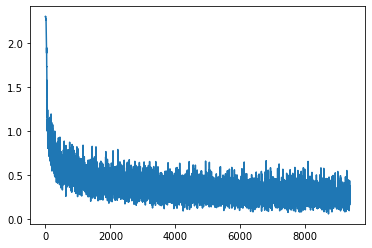

In [11]:
plt.plot(running_epoch_loss)

In [12]:
def eval_model(d_loader,mod):
    true_labels=[]
    pred_labels=[]
    pred_probs=[]
    for b,ex in enumerate(d_loader):
        pred=mod.forward(ex[0])
        pred_p=torch.softmax(pred,1)
        probs=np.max(pred_p.detach().numpy(),axis=1)
        labs=np.argmax(pred_p.detach().numpy(),axis=1)
        pred_labels.extend(labs)
        pred_probs.extend(probs)
        true_labels.extend(ex[1].detach().numpy())
    return(pred_labels,pred_probs,true_labels)


In [14]:
pred_labels_train,pred_probs_train,true_labels_train=eval_model(train_dataloader,model)
pred_labels_test,pred_probs_test,true_labels_test=eval_model(test_dataloader,model)

In [15]:
def get_conf_mat(pred_labels,true_labels,num_classes):
    cm=np.zeros([num_classes,num_classes])
    for k in range(len(pred_labels)):
        cm[true_labels[k],pred_labels[k]]+=1 
    return(cm)
train_conf_mat=get_conf_mat(pred_labels_train,true_labels_train,10)
test_conf_mat=get_conf_mat(pred_labels_test,true_labels_test,10)

In [16]:
train_acc=np.sum(np.diag(train_conf_mat))/np.sum(train_conf_mat)
test_acc=np.sum(np.diag(test_conf_mat))/np.sum(test_conf_mat)